In [1]:
!pip install qutip
!pip install ipywidgets
!pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.1/30.1 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.3 MB/s eta 0:00:00


In [2]:
import numpy as np
from scipy.optimize import minimize
import itertools
from functools import reduce
import matplotlib.pyplot as plt
from qutip import Bloch  # Only use QuTiP for Bloch spheres!
import matplotlib.patches as patches


## Multi-Qubit State Tomography using MLE

In [6]:
pauli_dict = {
    'I': np.array([[1,0],[0,1]]),
    'X': np.array([[0,1],[1,0]]),
    'Y': np.array([[0,-1j],[1j,0]]),
    'Z': np.array([[1,0],[0,-1]])
}

pauli_letters = ['I','X','Y','Z']

def generate_multi_qubit_state(thetas, phis, n_qubits):
    """
    Generate a multi-qubit pure state in polar form.
    Args:
        thetas: list of theta angles (in radians)
        phis: list of phi angles (in radians)
        n_qubits: number of qubits
    Returns:
        state: numpy array of shape (2**n_qubits, ) representing the quantum state
    """
    if len(thetas) != 2**n_qubits - 1:
        raise ValueError(f"Expected {2**n_qubits - 1} theta parameters, got {len(thetas)}.")
    if len(phis) != 2**n_qubits - 1:
        raise ValueError(f"Expected {2**n_qubits - 1} phi parameters, got {len(phis)}.")

    dim = int(2**n_qubits)
    state = np.zeros(dim, dtype=complex)

    amplitude = 1.0
    for idx in range(dim-1):
        state[idx] = amplitude * np.cos(thetas[idx]/2)
        amplitude = amplitude * np.sin(thetas[idx]/2)
        if idx > 0: state[idx] *= np.exp(1j * phis[idx-1])

    # Last component (no more theta to reduce amplitude)
    state[idx+1] = amplitude * np.exp(1j * phis[idx])

    # Normalize (should already be normalized, but just in case)
    # norm_state = np.linalg.norm(state)
    # if norm_state != 1: print("Error: Norm is ", norm_state)

    return state

def meas_prob(state, meas_op_string):
    dim = len(state)

    meas_op = [pauli_dict[op] for op in meas_op_string]
    M = reduce(np.kron, meas_op)

    proj_M = (np.eye(dim) + M)/2
    prob_plus1 = (np.conj(state).T) @ proj_M @ state

    return prob_plus1.real

def generate_samples(state, meas_op_string, n_shotsX, n_shotsY, n_shotsZ):
    """Simulate measurements in the given basis."""
    dim = len(state)
    n_qubit = len(meas_op_string)

    shots_list = []
    for q_idx in range(n_qubit):
      if meas_op_string[q_idx] == 'X':
        shots_list.append(n_shotsX)
      elif meas_op_string[q_idx] == 'Y':
        shots_list.append(n_shotsY)
      elif meas_op_string[q_idx] == 'Z':
        shots_list.append(n_shotsZ)

    n_shots = min(shots_list)

    prob_plus1 = meas_prob(state, meas_op_string)
    prob_minus1 = 1 - prob_plus1
    return np.random.choice([+1, -1], size=n_shots, p=[prob_plus1, prob_minus1])


def log_likelihood(params, samples):
    """Negative log-likelihood function."""
    n_qubits = int(np.log2(len(params)/2+1))
    n_theta_phi = int(len(true_params) // 2)

    thetas = params[0:n_theta_phi]
    phis = params[n_theta_phi:]

    state = generate_multi_qubit_state(thetas, phis, n_qubits)

    log_L = 0
    for setting in itertools.product(pauli_letters, repeat=n_qubits):
      if setting != ('I',) * n_qubits:
        prob_plus1 = meas_prob(state, setting)
        n_plus1 = np.sum(samples[setting] == +1)
        n_minus1 = np.sum(samples[setting] == -1)
        log_L += n_plus1 * np.log(prob_plus1 + 1e-10) + n_minus1 * np.log(1 - prob_plus1 + 1e-10)

    return -log_L

def estimate_parameters(n_qubits, samples):
    """Estimate θ and φ using MLE."""
    ### samples = {('I','X'): sampIX,('I','Y'): sampIY,....('X','X'): sampXX,...}
    opt_val = []
    opt_params = []
    for _ in range(50):
        theta_init = np.random.uniform(0, np.pi, size=2**n_qubits-1)
        phi_init = np.random.uniform(0, 2*np.pi, size=2**n_qubits-1)

        initial_params = np.concatenate([theta_init, phi_init])
        # print(initial_params)

        bounds = [(0, np.pi)] * (2**n_qubits-1) + [(0, 2*np.pi-0.01)] * (2**n_qubits-1)

        result = minimize(log_likelihood, initial_params, args=(samples),
                          bounds=bounds, method='L-BFGS-B')
        opt_val.append(result.fun)
        opt_params.append(result.x)

    result = min(opt_val)
    index = opt_val.index(result)
    result = opt_params[index]
    return result

def fidelity(state1, state2):
    """Compute fidelity between two quantum states."""
    return np.abs(np.vdot(state1, state2))**2

n_qubits = 2
true_thetas = [np.random.uniform(0,np.pi) for _ in range(2**n_qubits-1)]  # length = 2^2 - 1 = 3
true_phis = [np.random.uniform(0,2*np.pi) for _ in range(2**n_qubits-1)]        # same length

true_params = np.concatenate([true_thetas, true_phis])

n_theta_phi = int(len(true_params) // 2)

n_shotsX = 1000
n_shotsY = 1000
n_shotsZ = 1000

true_state = generate_multi_qubit_state(true_thetas, true_phis, n_qubits)

samples = {}
for setting in itertools.product(pauli_letters, repeat=n_qubits):
  if setting != ('I',) * n_qubits:
    # print(setting)
    samples[setting] = generate_samples(true_state, setting, n_shotsX, n_shotsY, n_shotsZ)

est_params = estimate_parameters(n_qubits, samples)
reconstructed_state = generate_multi_qubit_state(est_params[0:n_theta_phi], est_params[n_theta_phi:] , n_qubits)
fid = fidelity(true_state, reconstructed_state)

print("True parameters:", true_params)
print("Estimated parameters:", est_params)
print("Fidelity:", fid)

True parameters: [2.39420179 2.15977508 1.83167167 2.35419566 3.4796679  1.66144268]
Estimated parameters: [2.41003934 2.13240668 1.8513666  2.35779915 3.54464119 1.69078278]
Fidelity: 0.9991538908066551


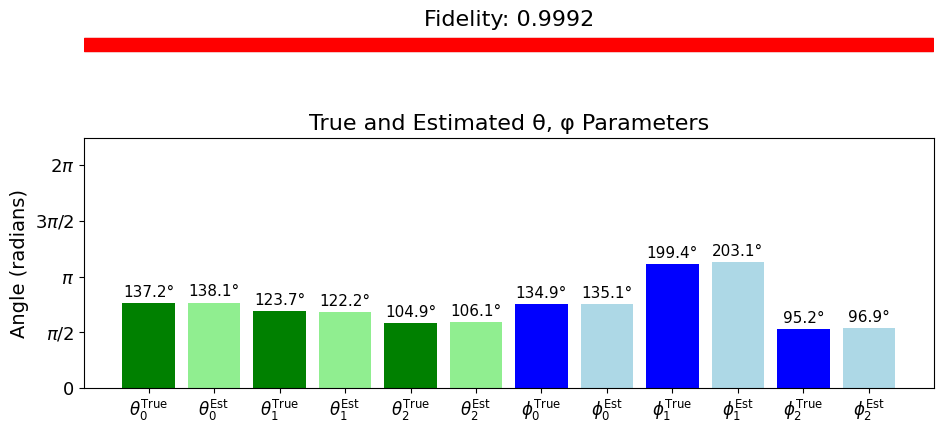

In [7]:
def plot_thetas_phis(true_thetas, true_phis, est_thetas, est_phis, fidelity):
    n_params = len(true_thetas)

    # Create main figure
    fig = plt.figure(figsize=(max(10, n_params*1.5), 5))
    gs = fig.add_gridspec(2, 1, height_ratios=[1, 4], hspace=0.4)

    # Fidelity gauge plot (top)
    ax_fid = fig.add_subplot(gs[0])
    ax_fid.set_xlim(0, 1)
    ax_fid.set_ylim(0, 1)
    ax_fid.axis('off')

    # Draw background and actual fidelity bar
    bg_bar = patches.Rectangle((0, 0.4), 1, 0.2, color='lightgray', ec='lightgray')
    fid_bar = patches.Rectangle((0, 0.4), fidelity, 0.2, color='red')
    ax_fid.add_patch(bg_bar)
    ax_fid.add_patch(fid_bar)

    ax_fid.text(0.5, 0.8, f"Fidelity: {fidelity:.4f}", ha='center', fontsize=16)

    # Bar plot for theta and phi (bottom)
    ax = fig.add_subplot(gs[1])

    labels = []
    values = []
    colors = []

    for i in range(n_params):
        labels.append(r'$\theta_{{{}}}^{{\text{{True}}}}$'.format(i))
        labels.append(r'$\theta_{{{}}}^{{\text{{Est}}}}$'.format(i))
        values.append(true_thetas[i])
        values.append(est_thetas[i])
        colors.append('green')
        colors.append('lightgreen')

    for i in range(n_params):
        labels.append(r'$\phi_{{{}}}^{{\text{{True}}}}$'.format(i))
        labels.append(r'$\phi_{{{}}}^{{\text{{Est}}}}$'.format(i))
        values.append(true_phis[i])
        values.append(est_phis[i])
        colors.append('blue')
        colors.append('lightblue')

    x_pos = np.arange(len(labels))

    ax.bar(x_pos, values, color=colors)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels, rotation=0, fontsize=12)

    # Y-axis in multiples of π
    yticks = [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]
    ytick_labels = ['0', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$']
    ax.set_yticks(yticks)
    ax.set_yticklabels(ytick_labels, fontsize=13)

    ax.set_ylim(0, 2*np.pi + 0.75)
    ax.set_ylabel('Angle (radians)', fontsize=14)
    ax.set_title('True and Estimated θ, φ Parameters', fontsize=16)

    # Add value annotations (in degrees) on top of each bar
    for i, val in enumerate(values):
        ax.text(i, val + 0.1, f"{np.degrees(val):.1f}°", ha='center', va='bottom', fontsize=11)

    fig.subplots_adjust(left=0.1, right=0.95, top=0.9, bottom=0.15, hspace=0.4)
    plt.show()

est_thetas = est_params[:n_theta_phi]
est_phis = est_params[n_theta_phi:]
plot_thetas_phis(true_thetas, true_phis, est_thetas, est_phis,fid)

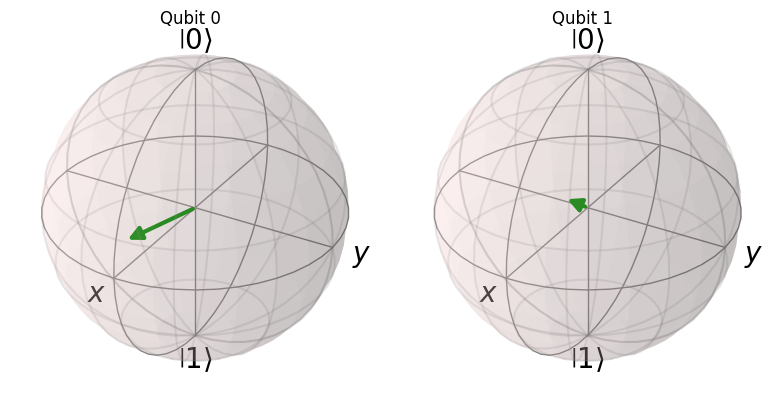

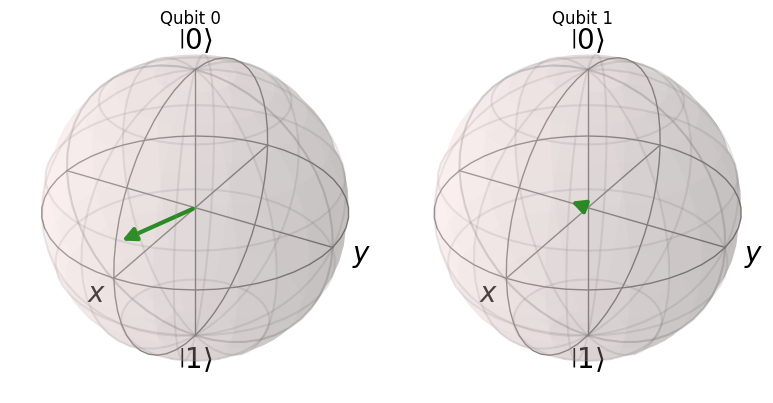

In [8]:
def partial_trace_density(rho, n_qubits, target_qubit):
    """
    Manual partial trace to obtain reduced density matrix for target qubit.
    rho: full density matrix (2^n x 2^n)
    n_qubits: number of qubits
    target_qubit: the qubit index to keep
    """
    dim = 2**n_qubits
    reduced_rho = np.zeros((2,2), dtype=complex)

    for i in range(dim):
        for j in range(dim):
            i_bits = [(i >> k) & 1 for k in range(n_qubits)][::-1]
            j_bits = [(j >> k) & 1 for k in range(n_qubits)][::-1]
            if all(i_bits[k] == j_bits[k] for k in range(n_qubits) if k != target_qubit):
                reduced_rho[i_bits[target_qubit], j_bits[target_qubit]] += rho[i,j]
    return reduced_rho

def bloch_vector_from_rho(rho):
    """
    Compute Bloch vector (x, y, z) from 2x2 density matrix.
    """
    x = 2 * np.real(rho[0,1])
    y = 2 * np.imag(rho[1,0])
    z = np.real(rho[0,0] - rho[1,1])
    return np.array([x, y, z])

def plot_multi_bloch_qutip(input_state, n_qubits):
    """
    Plot Bloch spheres using QuTiP Bloch class.
    """
    if len(input_state.shape) == 1:
        # Input is statevector
        rho = np.outer(input_state, input_state.conj())
    else:
        rho = input_state

    fig, axes = plt.subplots(1, n_qubits, figsize=(4*n_qubits, 4), subplot_kw={'projection': '3d'})

    if n_qubits == 1:
        axes = [axes]  # Make it iterable for 1 qubit

    for qubit in range(n_qubits):
        reduced_rho = partial_trace_density(rho, n_qubits, qubit)
        bloch_vec = bloch_vector_from_rho(reduced_rho)

        b = Bloch(axes=axes[qubit])
        b.add_vectors(bloch_vec)
        b.render()

        axes[qubit].set_title(f"Qubit {qubit}")

    plt.tight_layout()
    plt.show()

plot_multi_bloch_qutip(true_state, n_qubits)
plot_multi_bloch_qutip(reconstructed_state, n_qubits)